<div style="background-color:#2b0000; color:white; padding:25px; border-radius:10px; 
            text-align:center; font-family:'Segoe UI', sans-serif;">

  <h1 style="margin-bottom:8px;"> Cars 4 You 🏎️💨</h1>
  <h3 style="margin-top:0; font-style:italic; font-weight:normal; color:#f05a5a;">
    Auxiliary Notebook – Model Creation
  </h3>

  <hr style="width:60%; border:1px solid #700000; margin:15px auto;">

  <p style="margin:5px 0; font-size:15px;">
    <b>Group 4</b> - Machine Learning Project (2025/2026)
  </p>
  <p style="margin:0; font-size:13px; color:#e3bdbd;">
    Master in Data Science and Advanced Analytics - Nova Information Management School
  </p>
</div>

<br>

<div style="background-color:#3a0808; color:#f4eaea; padding:15px 20px; border-left:5px solid #700000; 
            border-radius:6px; font-family:'Segoe UI', sans-serif; font-size:14px;">

  <b>📘 Notebook Context</b><br>
  In this auxiliary notebook, we developed multiple models. We begin by importing the cleaned datasets, then establish a standardized model pipeline to streamline the process of training different algorithms.
</div>

<br>

<div style="text-align:center; margin-top:10px;">
  <a href="main.ipynb" 
     style="display:inline-block; background-color:#700000; color:#fff; 
            padding:8px 16px; text-decoration:none; border-radius:6px; 
            font-family:'Segoe UI', sans-serif; font-size:13px;">
     <- Back to Main Notebook
  </a>
</div>

<br>

<div style="text-align:right; font-size:12px; color:#d8bfbf;">
  Last updated: November 2025
</div>


In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import pickle
import matplotlib.pyplot as plt
from itertools import product
import random

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Cross Validation with the Created Folds

We previously created 5 folds and preprocessed train and validation there. The also created 5 different test sets, each one preprocessed with the information of one fold. 

Then we preprocessed a complete train dataset and preprocessed a complete test set with the information from the training dataset. 

Now, we will train models with cross-validation, training on the train set of the fold and assessing results on the validation set of the fold. We will use this to assess the best model.

Then, we will follow to approaches:
- We will assess results of test set on the model that resulted from each fold (on the test preprocessed with the data of that fold), and then we compute the average, getting our final predictions. 
- We will train the best model with the complete train dataset and assess on the test dataset, getting our final preditions.

### Pipeline

The objective is to:
- Train models on train dataset.
- Test model on test/validation dataset. F
- Regarding the last part, we will create a csv with the following format (carIDs of test dataframe):

    | carID | model_fold1 | model_fold2 | model_fold3 | model_fold4 | model_fold5 |
    |-------|-------------|-------------|-------------|-------------|-------------|
    | 1     | 10000       | 12000       | 11000       | …           | …           |
    | 2     | …           | …           | …           | …           | …           |
    | 3     | …           | …           | …           | …           | …           |

After this, we have 2 alternatives on how to use this pipeline:

- Either we use the average/median of the 5 predictions to build a submission dataset;

- Or we compare the performance results of the models across folds, to decide what is the better model, and then train a model with those characteristics on the full train data, to create a submission data.

## 1.1. Custom CV Version 

This function trains 5 models on the 5 aforementioned folds, automatically saving 3 metrics for all, generating a submission csv based on the mean/median of a car predictions on all folds.

In [16]:
def run_cv_pipeline_with_test(model_func, model_name, folds_dir, output_base_dir='./models'):
    """Run full CV pipeline: train, validate, predict on test with proper unscaling/unlogging"""
    
    # Create output directory
    output_dir = f'{output_base_dir}/{model_name}'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"Running CV Pipeline with Test for: {model_name}")
    print(f"{'='*70}\n")
    
    # Storage
    all_metrics = []
    test_predictions = {}
    
    # Iterate through folds
    for fold_idx in range(1, 6):
        print(f"[Fold {fold_idx}/5] Training and evaluating...")
        
        # Load data
        fold_path = f'{folds_dir}/fold_{fold_idx}'
        train_df = pd.read_csv(f'{fold_path}/train{fold_idx}_FINAL.csv')
        val_df = pd.read_csv(f'{fold_path}/validation{fold_idx}_FINAL.csv')
        
        # Prepare data
        X_train = train_df.drop(columns=['price_log'])
        y_train = train_df['price_log']
        X_val = val_df.drop(columns=['price_log'])
        y_val = val_df['price_log']
        
        # Train model
        model = model_func()
        model.fit(X_train, y_train)
        
        # Predict on validation
        y_pred = model.predict(X_val)
        

        ##### EXPORT
        #with open("model_exported.pkl", "wb") as f:
            #pickle.dump(model, f)
        #####


        # Load scaler
        scaler_path = f'{fold_path}/scaler.pkl'
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
            
        # Unscale and unlog for validation metrics
        price_log_idx = 10
        data_min = scaler.data_min_[price_log_idx]
        data_max = scaler.data_max_[price_log_idx]
        data_range = data_max - data_min
        
        # Step 1: Unscale (from [0,1] back to original log scale)
        y_val_log = y_val * data_range + data_min
        y_pred_log = y_pred * data_range + data_min
        
        # Step 2: Unlog (from log scale back to actual prices)
        y_val_actual = np.expm1(y_val_log)
        y_pred_actual = np.expm1(y_pred_log)
        
        # Calculate metrics on actual prices
        rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_actual))
        mae = mean_absolute_error(y_val_actual, y_pred_actual)
        r2 = r2_score(y_val, y_pred)  
        
        metrics = {'Fold': fold_idx, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
        all_metrics.append(metrics)
        
        print(f"  RMSE (actual price): ${rmse:.2f} | MAE (actual price): ${mae:.2f} | R2: {r2:.4f}")
        print(f"  Scaler check - price_log range: [{data_min:.6f}, {data_max:.6f}]")
        
        # Predict on test
        # currently scaled
        print(f"[Fold {fold_idx}/5] Predicting on test...")
        test_df = pd.read_csv(f'{fold_path}/test{fold_idx}_FINAL.csv')
        X_test = test_df.drop(columns=['carID'])
        car_ids = test_df['carID'].values
        
        # Predict on test (scaled)
        y_test_pred_scaled = model.predict(X_test)
        
        # Unscale and unlog test predictions
        y_test_pred_log = y_test_pred_scaled * data_range + data_min
        y_test_pred_actual = np.expm1(y_test_pred_log)
        
        # Store predictions
        #Since car_ids is identical across all 5 folds, storing it only once (on fold 1) is more efficient than storing it 5 times. 
        # once carID is added to the dictionary on the first iteration, it remains available for all subsequent folds when constructing the final predictions_df
        if fold_idx == 1:
            test_predictions['carID'] = car_ids
        
        test_predictions[f'model_fold{fold_idx}'] = y_test_pred_actual
        print(f"  Predictions: ${y_test_pred_actual.min():.2f} - ${y_test_pred_actual.max():.2f}\n")
    
    # ============= SAVE METRICS =============
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df = metrics_df[['Fold', 'RMSE', 'MAE', 'R2']]
    
    # Add average row
    avg_metrics = {
        'Fold': 'Average',
        'RMSE': metrics_df['RMSE'].mean(),
        'MAE': metrics_df['MAE'].mean(),
        'R2': metrics_df['R2'].mean()
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics])], ignore_index=True)
    
    metrics_path = f'{output_dir}/metrics.csv'
    metrics_df.to_csv(metrics_path, index=False)
    print(f"✓ Metrics saved to: {metrics_path}")
    print(metrics_df.to_string(index=False))
    print()
    
    # ============= SAVE FULL PREDICTIONS TABLE =============
    predictions_df = pd.DataFrame(test_predictions)
    predictions_path = f'{output_dir}/predictions_all_folds.csv'
    predictions_df.to_csv(predictions_path, index=False)
    print(f"✓ Full predictions saved to: {predictions_path}\n")
    
    # ============= SAVE SUBMISSION (AVERAGED) =============
    fold_cols = [f'model_fold{i}' for i in range(1, 6)]
    predictions_df['price'] = predictions_df[fold_cols].mean(axis=1) # <--------- CHANGE MEAN-MEDIAN (not that big of a difference on the tested models)
    
    submission_df = predictions_df[['carID', 'price']]
    submission_path = f'{output_dir}/submission_{model_name}.csv'
    submission_df.to_csv(submission_path, index=False)
    print(f"✓ Submission saved to: {submission_path}")
    print(f"  Preview:")
    print(submission_df.head().to_string(index=False))
    
    print(f"\n{'='*70}")
    print(f"Pipeline complete for: {model_name}")
    print(f"{'='*70}\n")
    
    return metrics_df


## 1.2. Model Definition

In this subchapter we will begin to implement sklearn models to the folds.
In this section, we will implement the following models:
- Linear Regression
- Support Vector Regressor
- Decision Tree Regressor
- KNN Regressor
- Gradient Boosting Regressor
- Random Forest Regressor

Later we will also implement Artificial Neural Networks

### 1.2.1 Linear Regression

Linear Regression models the relationship between input features and a continuous target variable by fitting a linear function:

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p
$$

The model estimates coefficients ($\beta$) that represent how much the target value changes when each feature increases by one unit, assuming all other features stay constant. 

The objective is to find coefficients that minimize the Mean Squared Error (MSE):

$$
\text{MSE}(\beta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where $y_i$ is the actual value and $\hat{y}_i$ is the predicted value.

In [17]:
def get_linear_regression():
    return LinearRegression()

metrics = run_cv_pipeline_with_test(
    model_func=get_linear_regression,
    model_name='linear_regression',
    folds_dir='./preprocessing_results/folds',
    output_base_dir='./models'
)


Running CV Pipeline with Test for: linear_regression

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $3572.24 | MAE (actual price): $2150.15 | R2: 0.8904
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $744.17 - $174366.28

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $3875.98 | MAE (actual price): $2223.05 | R2: 0.8840
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $736.40 - $167625.04

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $3887.47 | MAE (actual price): $2236.07 | R2: 0.8907
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $1016.41 - $145726.42

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $3950.54 | MAE (actual price): $2202.87 | R2: 0.8816
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting on test...
  Predictions: $783.6

### 1.2.2 Support Vector Regression (SVR)

Support Vector Regression (SVR) predicts a continuous target by finding a function that stays within a margin $\epsilon$ of the true values, while keeping the model as simple as possible. It only penalizes predictions that fall outside this margin, making it more robust to outliers than standard Linear Regression.

The SVR optimization problem:

$$
\frac{1}{2}\lVert w \rVert^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

is subject to constraints that enforce an **ε-insensitive margin** around the predictions.

- **$w$** — Weight Vector

- **$\tfrac{1}{2}\lVert w \rVert^2$** — Regularization Term

- **$C$** — Regularization Parameter

- **$\xi_i, \xi_i^*$** — Slack Variables - measure how much the prediction for sample $i$ exceeds the allowed $\epsilon$-insensitive margin. $\xi_i$ captures deviations above the margin, while $\xi_i^*$ captures deviations below it. If a prediction lies within the $\pm \epsilon$ tube, both slack variables are zero, where $\epsilon$ is the margin of tolerance

- **$n$** — Number of Training Samples

In the parameters called: 
- The **kernel** determines how the model maps the input data into a higher-dimensional space where a linear function can better fit nonlinear relationships. 
  
- The **gamma** parameter controls how far the influence of a single training point extends: a **small gamma** produces a smoother, more general function because each point affects a wide region, while a **large gamma** makes the model focus tightly around individual points, increasing flexibility but also the risk of overfitting.

After trying different combinations of parameters, changing epsilon, gamma and the regularization parameter, we found it hard for the MAE to decrease under 2000.

In [18]:
def get_svr():
    return SVR()

'''
# arguments for SVR
kernel='rbf',   # can also use 'linear' or 'poly'
C=0.5,          # regularization parameter
epsilon=0.1,    # margin of tolerance
gamma=0.5       # kernel coefficient
'''

metrics = run_cv_pipeline_with_test(
    model_func=get_svr,
    model_name='svr',
    folds_dir='./preprocessing_results/folds',
    output_base_dir='./models'
)


Running CV Pipeline with Test for: svr

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $4202.01 | MAE (actual price): $2590.16 | R2: 0.8656
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $919.24 - $82384.92

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $4218.58 | MAE (actual price): $2599.19 | R2: 0.8506
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $521.79 - $86287.69

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $4355.00 | MAE (actual price): $2594.93 | R2: 0.8674
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $546.88 - $85379.88

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $4449.71 | MAE (actual price): $2668.29 | R2: 0.8586
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting on test...
  Predictions: $722.68 - $81569.22

[Fo

### 1.2.3 Decision Tree Regressor

Decision Tree Regression predicts a continuous target by recursively splitting the data into regions that minimize prediction error. At each split, the algorithm chooses the feature and threshold that yield the largest reduction in mean squared error (MSE).

At each node, the algorithm searches for the feature $j$ and threshold $t$ that minimize the combined impurity of the resulting child nodes, where the MSE for each region is:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y})^2
$$

and $\hat{y}$ is the mean target value of all samples in that region.

Although, it is **prone to overfitting** without proper regularization.

In [19]:
def get_dt():
    return DecisionTreeRegressor()

metrics = run_cv_pipeline_with_test(
    model_func=get_dt,
    model_name='dt',
    folds_dir='./preprocessing_results/folds',
    output_base_dir='./models'
)


Running CV Pipeline with Test for: dt

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $2867.88 | MAE (actual price): $1678.47 | R2: 0.9118
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $650.00 - $159999.00

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $3248.73 | MAE (actual price): $1738.61 | R2: 0.9064
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $495.00 - $149948.00

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $2958.49 | MAE (actual price): $1697.36 | R2: 0.9147
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $495.00 - $139995.00

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $3028.50 | MAE (actual price): $1695.97 | R2: 0.9114
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting on test...
  Predictions: $495.00 - $137995.00



### 1.2.4 k-Nearest Neighbors (kNN) Regression

kNN Regression predicts a continuous target by averaging the outputs of the $k$ closest training points to a query sample. The prediction for a query point $x$ is:

$$
\hat{y}(x) = \frac{1}{k} \sum_{i=1}^k y_i
$$

where $y_i$ are the target values of the $k$ nearest neighbors.

**Distance metrics:**

"Closeness" is typically measured using one of these distance functions:

- **Euclidean**: $d(x, y) = \sqrt{\sum_i (x_i - y_i)^2}$
  
- **Manhattan**: $d(x, y) = \sum_i |x_i - y_i|$
  
- **Chebyshev**: $d(x, y) = \max_i |x_i - y_i|$


In [20]:
distance_metrics = ['euclidean', 'manhattan', 'chebyshev'] 
results = []

def get_knn(metric):
    return KNeighborsRegressor(
        n_neighbors=10,
        weights='distance',
        metric=metric,
        n_jobs=-1
    )

for metric in distance_metrics:
    print(f"Running KNN with metric: {metric}")

    metrics = run_cv_pipeline_with_test(
        model_func=lambda: get_knn(metric),
        model_name=f'knn_{metric}',
        folds_dir='./preprocessing_results/folds',
        output_base_dir='./models'
    )

    # metrics already contains the average row 
    avg_row = metrics[metrics['Fold'] == 'Average'].iloc[0]

    results.append({
        'metric': metric,
        'RMSE': avg_row['RMSE'],
        'MAE': avg_row['MAE'],
        'R2': avg_row['R2']
    })

results_df = pd.DataFrame(results)
print(results_df)

Running KNN with metric: euclidean

Running CV Pipeline with Test for: knn_euclidean

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $2677.86 | MAE (actual price): $1565.01 | R2: 0.9287
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $1050.22 - $135280.42

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $3050.80 | MAE (actual price): $1667.12 | R2: 0.9245
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $878.31 - $115377.77

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $3010.61 | MAE (actual price): $1601.82 | R2: 0.9323
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $1040.15 - $133722.04

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $3021.44 | MAE (actual price): $1577.03 | R2: 0.9290
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting 

In [21]:
results_df

,metric,RMSE,MAE,R2
0,euclidean,2892.172113,1610.670123,0.928419
1,manhattan,2670.887997,1503.634212,0.937553
2,chebyshev,3140.989659,1728.212994,0.907073


### 1.2.5 Gradient Boosting Regression

Gradient Boosting Regression predicts a continuous target by sequentially building an ensemble of decision trees, where each new tree is trained to correct the residuals of the previous ones.

In [22]:
def get_gb():
    return GradientBoostingRegressor()

metrics_gb = run_cv_pipeline_with_test(
    model_func=get_gb,
    model_name='gb',
    folds_dir='./preprocessing_results/folds',
    output_base_dir='./models'
)


Running CV Pipeline with Test for: gb

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $2797.29 | MAE (actual price): $1790.09 | R2: 0.9251
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $1093.55 - $121873.52

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $3138.11 | MAE (actual price): $1835.41 | R2: 0.9228
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $1217.35 - $114460.75

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $3128.17 | MAE (actual price): $1838.00 | R2: 0.9280
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $1011.40 - $119369.17

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $3116.33 | MAE (actual price): $1805.10 | R2: 0.9233
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting on test...
  Predictions: $885.61 - $115398.5

### 1.2.6 Random Forest Regression 

Random Forest Regression predicts a continuous target by averaging the predictions of multiple decision trees, each trained on a random subset of the data and features. This reduces overfitting and improves generalization compared to a single decision tree.

In [23]:
def get_rf(): 
    return RandomForestRegressor() 

metrics_rf = run_cv_pipeline_with_test( 
    model_func=get_rf, 
    model_name='rf', 
    folds_dir='./preprocessing_results/folds', 
    output_base_dir='./models' 
)


Running CV Pipeline with Test for: rf

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $2139.04 | MAE (actual price): $1310.43 | R2: 0.9490
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $1080.59 - $138052.39

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $2375.80 | MAE (actual price): $1347.02 | R2: 0.9449
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $753.54 - $135044.50

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $2385.20 | MAE (actual price): $1341.63 | R2: 0.9495
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $654.98 - $132568.14

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $2477.21 | MAE (actual price): $1335.45 | R2: 0.9466
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting on test...
  Predictions: $680.56 - $134471.79


### 1.2.7 Multilayer Perceptron Regression 

Multilayer Perceptron Regression predicts a continuous target using a neural network with one or more hidden layers. Each layer contains neurons that apply weighted transformations and activation functions, learning complex non-linear patterns through backpropagation to minimize prediction error.

The output of a neuron in layer $l$ is computed as:

$$a_j^{(l)} = f\left(\sum_{i} w_{ji}^{(l)} a_i^{(l-1)} + b_j^{(l)}\right)$$

where $w_{ji}^{(l)}$ are the weights, $b_j^{(l)}$ is the bias, $a_i^{(l-1)}$ are inputs from the previous layer, and $f$ is the activation function.

In [24]:
def get_nn():
    return MLPRegressor()

metrics = run_cv_pipeline_with_test(
    model_func=get_nn,
    model_name='nn',
    folds_dir='./preprocessing_results/folds',
    output_base_dir='./models'
)



Running CV Pipeline with Test for: nn

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $3744.89 | MAE (actual price): $2195.40 | R2: 0.8850
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $770.99 - $158000.56

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $4658.24 | MAE (actual price): $2220.86 | R2: 0.8758
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $534.97 - $145735.65

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $3819.04 | MAE (actual price): $2115.87 | R2: 0.8997
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $787.29 - $126783.60

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $3905.44 | MAE (actual price): $2110.20 | R2: 0.8922
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting on test...
  Predictions: $813.17 - $148366.97



## 1.3. Compare performance across models

To do so, we need to iterate through the "/models" files and append the average among folds of all metrics on a unique dataframe. Pipeline structure:

- Iterates through `/models`

- Goes into subfolders (dt, knn_euclidean...)

- Reads "metrics.csv" in each folder, name is the same on all;

- Extracts the last row (which has the averages);

- Appends that to a new summary dataset.

In [25]:
def summarize_model_metrics(models_path="models"):
    """
    Summarizes average metrics from metrics.csv in each subfolder of models_path.
    """
    models_path = Path(models_path)
    summary_data = []

    # Iterate over all subfolders in models folder
    for model_folder in models_path.iterdir():
        if model_folder.is_dir():
            csv_file = model_folder / "metrics.csv"
            if csv_file.exists(): # ensure file existence for sanity 
                df = pd.read_csv(csv_file)
                last_row = df.iloc[-1]  # last row has averages
                
                summary_data.append({
                    "folder_name": model_folder.name,
                    "RMSE": last_row["RMSE"],
                    "MAE": last_row["MAE"],
                    "R2": last_row["R2"]
                })

    # Convert summary to DataFrame
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [26]:
summary = summarize_model_metrics()
summary

,folder_name,RMSE,MAE,R2
0,svr,4271.748307,2614.990964,0.859162
1,nn,3936.635065,2151.534937,0.889425
2,dt,3023.464770,1696.635199,0.911405
3,rf,2307.405253,1332.049634,0.947733
4,linear_regression,3767.035995,2200.262185,0.887030
5,knn_chebyshev,3140.989659,1728.212994,0.907073
6,gb,2995.974453,1815.488282,0.924732
7,knn_euclidean,2892.172113,1610.670123,0.928419
8,knn_manhattan,2670.887997,1503.634212,0.937553


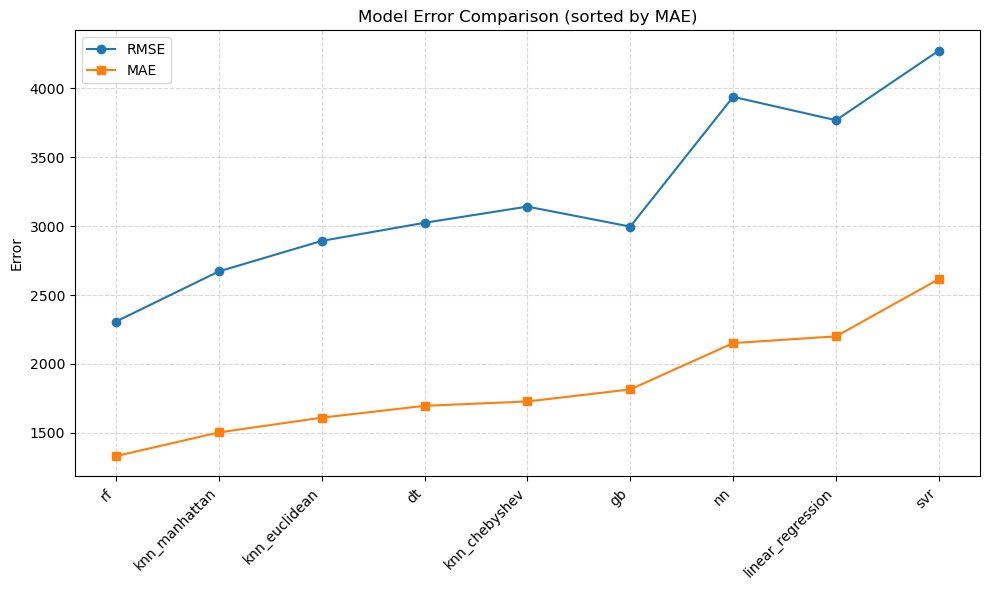

In [27]:
# Sort DataFrame by MAE
df_sorted = summary.sort_values(by="MAE", ascending=True)

# X-axis: folder names
models = df_sorted["folder_name"]

plt.figure(figsize=(10, 6))

# Plot RMSE
plt.plot(models, df_sorted["RMSE"], marker='o', label="RMSE")

# Plot MAE
plt.plot(models, df_sorted["MAE"], marker='s', label="MAE")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Error")
plt.title("Model Error Comparison (sorted by MAE)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Comparing the models, without fine tuning parameters, we can see that Random Forest performs the best, followed by KNN with Manhattan distance. Linear Regression and SVR have a significantly worse performance.

Further hyperparameter tuning could **potentially improve the performance of all models**. However, we will focus on tuning the hyperparameters for the random forest, which seems to have by far the best results.

# 2. Hyperparameter Tuning on Random Forest

To do so, we will define a grid of hyperparameters to test, run the CV pipeline for each combination, and store the results for comparison. This approach is useful for improving the model performance, and since we are using the aforementioned folds, the choice of hyperparameters won't be overfitting on a single data split, and instead will be pondered across folds.

## 2.1. Parameter Grid Definition

The parameters tested are the following:

#### 1. `n_estimators` — Number of Trees

The number of decision trees in the Random Forest ensemble. **Each tree is trained on a bootstrap sample, and their predictions are averaged**.

- More trees: more stable predictions, reduced variance
- Too many trees: slower training and prediction, diminishing returns

#### 2. `max_depth` — Maximum Depth of Each Tree

The maximum number of levels a tree can grow before stopping.

- Shallow trees (small depth): more bias, less overfitting
- Deep trees (large depth or None): can capture complex patterns but may overfit

#### 3. `min_samples_split` — Minimum Samples to Split an Internal Node

The minimum number of samples required to split a node into two child nodes. Varying the number changes the tree structure.

#### 4. `min_samples_leaf` — Minimum Samples Required at a Leaf Node

The minimum number of training samples that must end up in each leaf node. Varying the number also changes the tree structure.

#### 5. `bootstrap` — Whether Bootstrapping Is Used

Controls whether each tree is trained on a *bootstrap sample* (random sampling with replacement) of the dataset.

- **True** → standard Random Forest (trees get different samples, more diverse)
- **False** → all trees see the full dataset (less randomness, may overfit more)

In [28]:
"""
rf_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 30, 50],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    "bootstrap": [True, False]
}

results_rf = []

def get_rf_with_params(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap):
    return RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )


# Iterate over all combinations
for n_est, depth, split, leaf, boot in product(
    rf_param_grid['n_estimators'],
    rf_param_grid['max_depth'],
    rf_param_grid['min_samples_split'],
    rf_param_grid['min_samples_leaf'],
    rf_param_grid['bootstrap']
):

    # Compose folder name 
    model_name = (
        f"rf_n{n_est}_d{depth}_split{split}_leaf{leaf}_{'boot' if boot else 'noboot'}"
    )

    print(f"Training model: {model_name}")

    metrics = run_cv_pipeline_with_test(
        model_func=lambda ne=n_est, d=depth, s=split, l=leaf, b=boot: 
            get_rf_with_params(ne, d, s, l, b),
        model_name=model_name,
        folds_dir='./preprocessing_results/folds',
        output_base_dir='./models_rf_tuning'
    )

    avg_row = metrics[metrics['Fold'] == 'Average'].iloc[0]

    results_rf.append({
        'model': model_name,
        'n_estimators': n_est,
        'max_depth': depth,
        'min_samples_split': split,
        'min_samples_leaf': leaf,
        'bootstrap': boot,
        'RMSE': avg_row['RMSE'],
        'MAE': avg_row['MAE'],
        'R2': avg_row['R2']
    })

# Convert to df
results_rf_df = pd.DataFrame(results_rf)
print(results_rf_df)
"""


'\nrf_param_grid = {\n    \'n_estimators\': [100, 500, 1000],\n    \'max_depth\': [10, 30, 50],\n    \'min_samples_split\': [5, 10],\n    \'min_samples_leaf\': [2, 5],\n    "bootstrap": [True, False]\n}\n\nresults_rf = []\n\ndef get_rf_with_params(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap):\n    return RandomForestRegressor(\n        n_estimators=n_estimators,\n        max_depth=max_depth,\n        min_samples_split=min_samples_split,\n        min_samples_leaf=min_samples_leaf,\n        bootstrap=bootstrap,\n        random_state=42,\n        n_jobs=-1\n    )\n\n\n# Iterate over all combinations\nfor n_est, depth, split, leaf, boot in product(\n    rf_param_grid[\'n_estimators\'],\n    rf_param_grid[\'max_depth\'],\n    rf_param_grid[\'min_samples_split\'],\n    rf_param_grid[\'min_samples_leaf\'],\n    rf_param_grid[\'bootstrap\']\n):\n\n    # Compose folder name \n    model_name = (\n        f"rf_n{n_est}_d{depth}_split{split}_leaf{leaf}_{\'boot\' if boot

In [30]:
# results_rf_df.to_csv('./models_rf_tuning/rf_hyperparameter_tuning_results.csv', index=False)

## 2.2. Accessing Effect of Hyperarameter Variations on Model Performance

We need to systematize a way to compare correctly the impact of varying hyperparameters on model performance.

To do so, we decided to visualize said impact by grouping the results dataframe by individual hyperparameter chosen, and then compare the average performance with it.

### 2.2.1 Number of Estimators

In [31]:
def plot_n_estimators_comparison(results_df, figsize=(10, 6)):
    # Group by n_estimators and calculate mean metrics
    grouped = results_df.groupby('n_estimators')[['MAE', 'RMSE']].mean()
    
    # Setup figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # X-axis positions
    x_positions = np.arange(len(grouped))
    bar_width = 0.25
    
    # Create bars
    bars1 = ax.bar(x_positions - bar_width/2, grouped['MAE'], bar_width, 
                   label='MAE', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x_positions + bar_width/2, grouped['RMSE'], bar_width, 
                   label='RMSE', color='coral', alpha=0.8)
    
    # Customize axes
    ax.set_xlabel('Number of Estimators', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE / RMSE', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Effect of Number of Estimators', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(grouped.index)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig

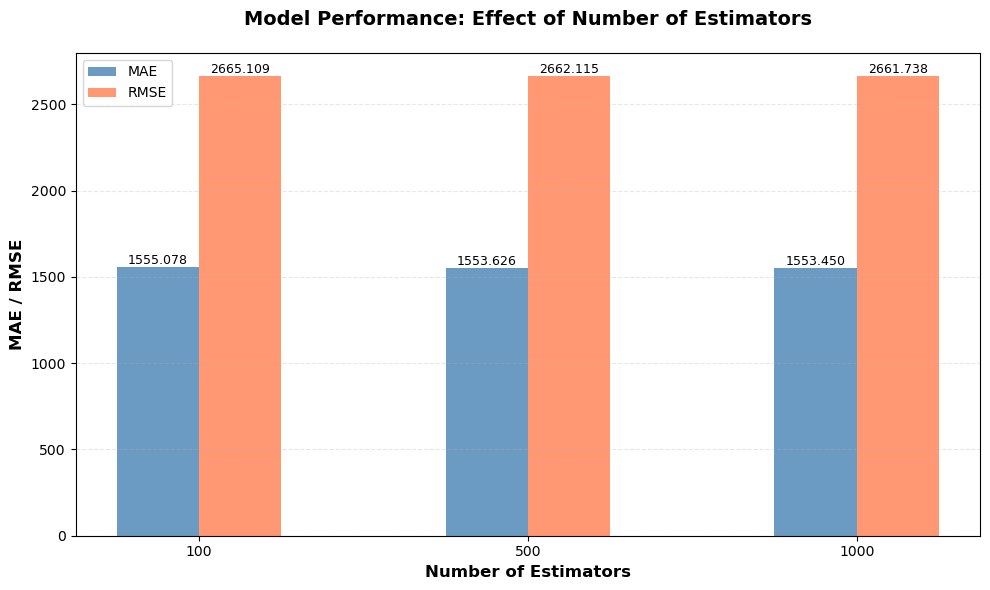

In [32]:
results_df = pd.read_csv('./models_rf_tuning/rf_hyperparameter_tuning_results.csv')

fig = plot_n_estimators_comparison(results_df)
fig.savefig("./plots_imported_on_main/num_estimators.png")

plt.show()

### 2.2.2 Max Depth

In [33]:
def plot_max_depth_comparison(results_df, figsize=(10, 6)):
    # Group by max_depth and calculate mean metrics
    grouped = results_df.groupby('max_depth')[['MAE', 'RMSE']].mean()
    
    # Setup figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # X-axis positions
    x_positions = np.arange(len(grouped))
    bar_width = 0.35
    
    # Create bars
    bars1 = ax.bar(x_positions - bar_width/2, grouped['MAE'], bar_width, 
                   label='MAE', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x_positions + bar_width/2, grouped['RMSE'], bar_width, 
                   label='RMSE', color='coral', alpha=0.8)
    
    # Customize axes
    ax.set_xlabel('Maximum Depth', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE / RMSE', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Effect of Maximum Depth', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([str(int(x)) if x is not None else 'None' for x in grouped.index])
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig

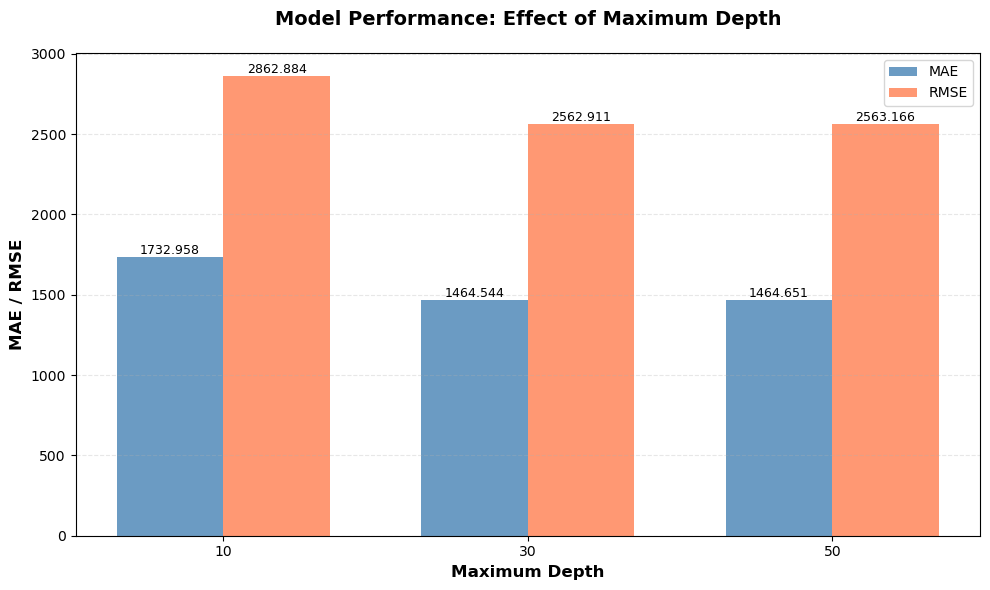

In [34]:
#results_df = pd.read_csv('./models_rf_tuning/rf_hyperparameter_tuning_results.csv')
    
# Create plot
fig = plot_max_depth_comparison(results_df)
fig.savefig("./plots_imported_on_main/max_depth.png")

plt.show()

### 2.2.3 Minimum Samples to Split Internal Node

In [35]:
def plot_min_samples_split_comparison(results_df, figsize=(10, 6)):
    # Group by min_samples_split and calculate mean metrics
    grouped = results_df.groupby('min_samples_split')[['MAE', 'RMSE']].mean()
    
    # Setup figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # X-axis positions
    x_positions = np.arange(len(grouped))
    bar_width = 0.35
    
    # Create bars
    bars1 = ax.bar(x_positions - bar_width/2, grouped['MAE'], bar_width, 
                   label='MAE', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x_positions + bar_width/2, grouped['RMSE'], bar_width, 
                   label='RMSE', color='coral', alpha=0.8)
    
    # Customize axes
    ax.set_xlabel('Minimum Samples Split', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE / RMSE', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Effect of Minimum Samples Split', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(grouped.index)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig

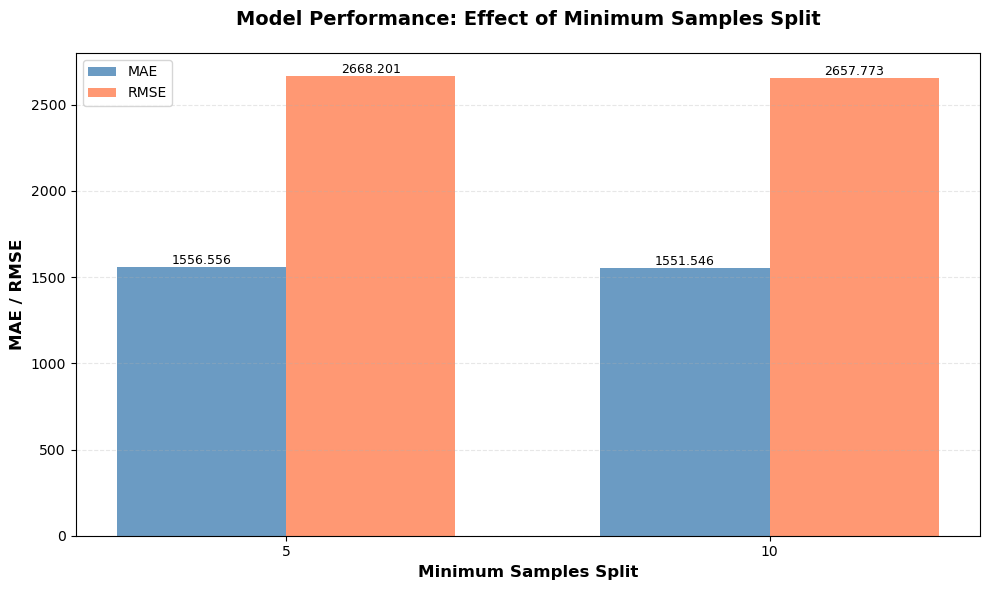

In [36]:
#results_df = pd.read_csv('./models_rf_tuning/rf_hyperparameter_tuning_results.csv')
    
# Create plot
fig = plot_min_samples_split_comparison(results_df)
fig.savefig("./plots_imported_on_main/min_samples_split.png")

plt.show()

### 2.2.4 Minimum Samples Required at a Leaf Node

In [37]:
def plot_min_samples_leaf_comparison(results_df, figsize=(10, 6)):
    # Group by min_samples_leaf and calculate mean metrics
    grouped = results_df.groupby('min_samples_leaf')[['MAE', 'RMSE']].mean()
    
    # Setup figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # X-axis positions
    x_positions = np.arange(len(grouped))
    bar_width = 0.35
    
    # Create bars
    bars1 = ax.bar(x_positions - bar_width/2, grouped['MAE'], bar_width, 
                   label='MAE', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x_positions + bar_width/2, grouped['RMSE'], bar_width, 
                   label='RMSE', color='coral', alpha=0.8)
    
    # Customize axes
    ax.set_xlabel('Minimum Samples Leaf', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE / RMSE', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Effect of Minimum Samples Leaf', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(grouped.index)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig

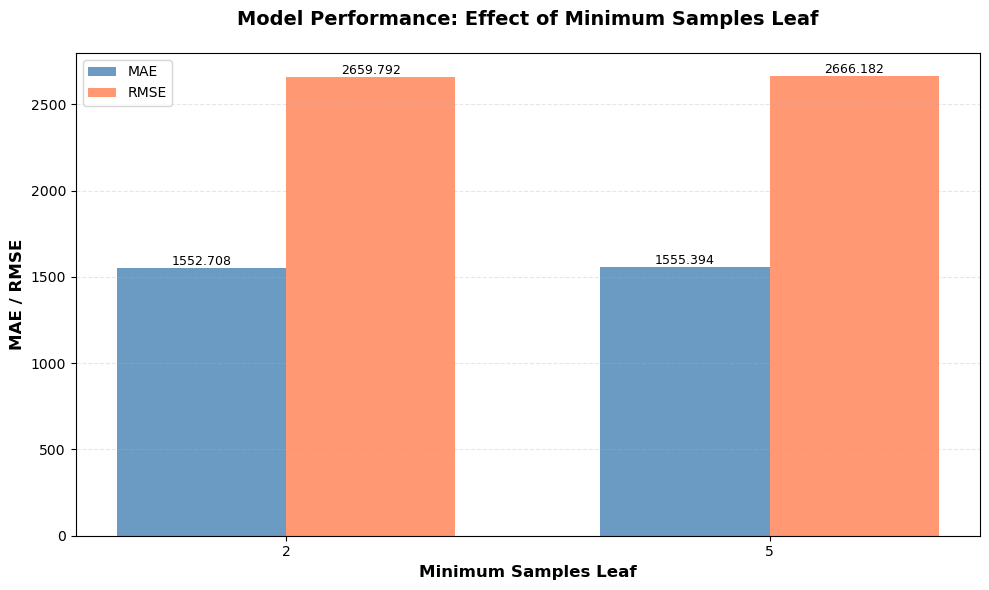

In [38]:
#results_df = pd.read_csv('./models_rf_tuning/rf_hyperparameter_tuning_results.csv')
    
# Create plot
fig = plot_min_samples_leaf_comparison(results_df)
fig.savefig("./plots_imported_on_main/min_samples_leaf.png")

plt.show()

### 2.2.5 Bootstrap

In [39]:
def plot_bootstrap_comparison(results_df, figsize=(8, 6)):
    """
    Plot MAE and RMSE grouped by bootstrap with grouped bars.
    
    Parameters:
    -----------
    results_df : pd.DataFrame, results from hyperparameter tuning
    figsize : tuple, figure size
    """
    
    # Group by bootstrap and calculate mean metrics
    grouped = results_df.groupby('bootstrap')[['MAE', 'RMSE']].mean()
    
    # Setup figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # X-axis positions
    x_positions = np.arange(len(grouped))
    bar_width = 0.35
    
    # Create bars
    bars1 = ax.bar(x_positions - bar_width/2, grouped['MAE'], bar_width, 
                   label='MAE', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x_positions + bar_width/2, grouped['RMSE'], bar_width, 
                   label='RMSE', color='coral', alpha=0.8)
    
    # Customize axes
    ax.set_xlabel('Bootstrap', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE / RMSE', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Effect of Bootstrap Sampling', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['False', 'True'])
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig

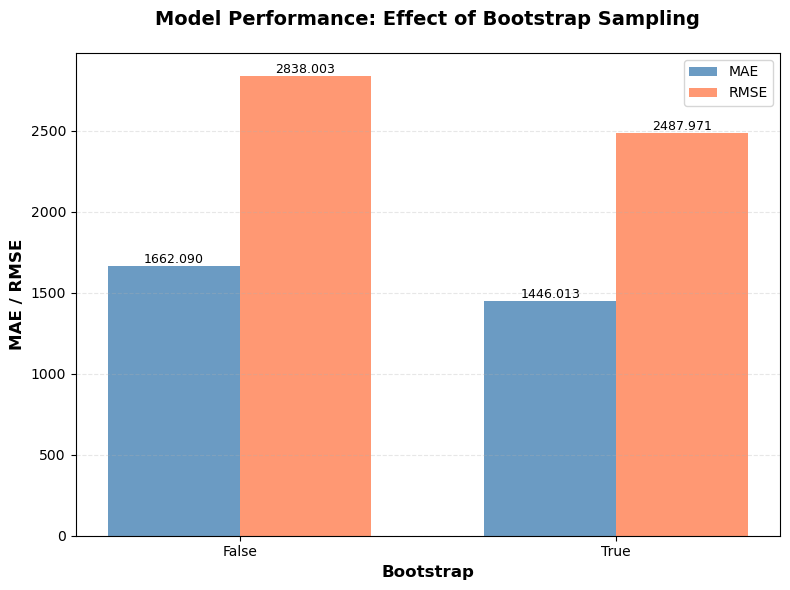

In [40]:
#results_df = pd.read_csv('./models_rf_tuning/rf_hyperparameter_tuning_results.csv')

fig = plot_bootstrap_comparison(results_df)
fig.savefig("./plots_imported_on_main/bootstrap.png")

plt.show()

## 2.3. Conclusion on Hyperparameter Tuning

By analysing the plots, we can draw several conclusions about the impact of different hyperparameters on model performance:

- **Maximum Depth**: By analysing the plot, we can confirm that varying it impacts the model significantly. The models performance improved from 10 to 30 max depth, but plateau'd from there onwards.

- **Bootstrap**: Applying Bootstrap impacted the models performance as well, since on average, when bootstrap is applied, the models obtain a MAE of approximately -220, and RMSE of approximately -350.

The rest of the hyperparameter variation impact on models performance can be considered neglible.

In [41]:
def display_top_models(results_df, top_n=3):
    """
    Display top models sorted by different metrics.
    
    Parameters:
    -----------
    results_df : pd.DataFrame, results from hyperparameter tuning
    top_n : int, number of top models to display
    """
    
    print("="*100)
    print("TOP 3 MODELS - SORTED BY MAE")
    print("="*100)
    top_mae = results_df.nsmallest(top_n, 'MAE')
    print(top_mae[['model', 'n_estimators', 'max_depth', 'min_samples_split', 
                   'min_samples_leaf', 'bootstrap', 'MAE', 'RMSE', 'R2']].to_string(index=False))
    print()
    
    print("="*100)
    print("TOP 3 MODELS - SORTED BY RMSE")
    print("="*100)
    top_rmse = results_df.nsmallest(top_n, 'RMSE')
    print(top_rmse[['model', 'n_estimators', 'max_depth', 'min_samples_split', 
                    'min_samples_leaf', 'bootstrap', 'MAE', 'RMSE', 'R2']].to_string(index=False))
    print()
    
    print("="*100)
    print("TOP 3 MODELS - SORTED BY R2 (Higher is Better)")
    print("="*100)
    top_r2 = results_df.nlargest(top_n, 'R2')
    print(top_r2[['model', 'n_estimators', 'max_depth', 'min_samples_split', 
                  'min_samples_leaf', 'bootstrap', 'MAE', 'RMSE', 'R2']].to_string(index=False))
    print()

results_df = pd.read_csv('./models_rf_tuning/rf_hyperparameter_tuning_results.csv')
print(f"\nTotal models evaluated: {len(results_df)}\n")
    
# Display top models by each metric
display_top_models(results_df, top_n=3)


Total models evaluated: 72

TOP 3 MODELS - SORTED BY MAE
                         model  n_estimators  max_depth  min_samples_split  min_samples_leaf  bootstrap         MAE        RMSE       R2
rf_n1000_d30_split5_leaf2_boot          1000         30                  5                 2       True 1323.369113 2318.569892 0.948705
rf_n1000_d50_split5_leaf2_boot          1000         50                  5                 2       True 1323.407733 2319.001046 0.948705
 rf_n500_d30_split5_leaf2_boot           500         30                  5                 2       True 1323.849217 2318.751907 0.948680

TOP 3 MODELS - SORTED BY RMSE
                         model  n_estimators  max_depth  min_samples_split  min_samples_leaf  bootstrap         MAE        RMSE       R2
rf_n1000_d30_split5_leaf2_boot          1000         30                  5                 2       True 1323.369113 2318.569892 0.948705
 rf_n500_d30_split5_leaf2_boot           500         30                  5               

**The best model overall appears to be the one with:**

**1000 estimators, a maximum depth of 30, minimum samples split of 5, minimum samples leaf of 2, and bootstrap=True, achieving an RMSE of 2319, MAE of 1323, and R-squared of almost 0.95.**

This model configuration provides the best performance across all metrics:
- **Lowest error** (RMSE and MAE)
- **Highest R² score** (0.949), explaining almost 95% of the variance in the target variable

# 3. Finalizing Non Deep-Learning Models

After accessing which model and parameters behave best on the validation sets during cross-validation, we can now train a final model on the entire training dataset and generate predictions for the test set without cross-validation. 

This approach allows us to leverage all available training data for model training.

In [42]:
def run_pipeline_no_cv(model_func, model_name, 
                       output_base_dir='./models_best'):
    
    results_dir = './preprocessing_results/full_dataset'
    train_path=f"{results_dir}/train_FINAL.csv"
    test_path=f"{results_dir}/test_FINAL.csv"
    # Create output directory
    output_dir = f'{output_base_dir}/{model_name}'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"Running Pipeline (No CV) for: {model_name}")
    print(f"{'='*70}\n")
    
    # Load complete train dataset
    print(f"Loading train data...")
    train_df = pd.read_csv(train_path)
    print(f"  Train shape: {train_df.shape}")

    print(f"  Train columns: {train_df.columns.tolist()}")
    
    # Load complete test dataset
    print(f"Loading test data...")
    test_df = pd.read_csv(test_path)
    print(f"  Test shape: {test_df.shape}")
    print(f"  Test columns: {test_df.columns.tolist()}\n")
    
    # Get price_log index BEFORE dropping it from training data
    # This matches how the scaler was fit - on all features including price_log
    train_columns_with_target = train_df.columns.tolist()
    price_log_idx = train_columns_with_target.index('price_log')
    print(f"  price_log is at index {price_log_idx}")
    
    # Prepare training data
    X_train = train_df.drop(columns=['price_log'])
    y_train = train_df['price_log']
    
    # Prepare test data
    X_test = test_df.drop(columns=['carID'])
    car_ids = test_df['carID'].values 
    
    # Train model
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(X_train, y_train)
    print(f"  ✓ Model trained\n")
    
    # Predict on test
    print(f"Generating predictions on test set...")
    y_test_pred_scaled = model.predict(X_test)
    
    # Load scaler to unscale predictions
    scaler_path = f'{results_dir}/scaler.pkl'
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    price_log_idx = 10
    data_min = scaler.data_min_[price_log_idx]
    data_max = scaler.data_max_[price_log_idx]
    data_range = data_max - data_min
    
    # Unscale and unlog test predictions
    y_test_pred_log = y_test_pred_scaled * data_range + data_min
    y_test_pred_actual = np.expm1(y_test_pred_log)
    
    print(f"  Predictions range: ${y_test_pred_actual.min():.2f} - ${y_test_pred_actual.max():.2f}\n")
    
    # ============= SAVE SUBMISSION =============
    
    submission_df = pd.DataFrame({
        'carID': car_ids,
        'price': y_test_pred_actual
    })
    
    submission_path = f'{output_dir}/submission_{model_name}.csv'
    submission_df.to_csv(submission_path, index=False)
    
    print(f"✓ Submission saved to: {submission_path}")
    print(f"  Preview:")
    print(submission_df.head().to_string(index=False))
    
    print(f"\n{'='*70}")
    print(f"Pipeline complete for: {model_name}")
    print(f"{'='*70}\n")
    
    return submission_df

In [43]:
def get_best_rf():
    return RandomForestRegressor(
        n_estimators=1000,
        max_depth=30,
        min_samples_split=5,
        min_samples_leaf=2,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

## 3.1. Applying the Best Random Forest on Full Dataset - 12910 on Kaggle

In [44]:
run_pipeline_no_cv(
    model_func=lambda: get_best_rf(),
    model_name='random_forest_noCV',
)


Running Pipeline (No CV) for: random_forest_noCV

Loading train data...
  Train shape: (74402, 11)
  Train columns: ['model_encoded', 'tax', 'car_age', 'mileage', 'mpg', 'engineSize', 'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Hybrid', 'price_log']
Loading test data...
  Test shape: (32567, 11)
  Test columns: ['carID', 'model_encoded', 'tax', 'car_age', 'mileage', 'mpg', 'engineSize', 'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Hybrid']

  price_log is at index 10
Training random_forest_noCV...
  ✓ Model trained

Generating predictions on test set...
  Predictions range: $846.80 - $139413.28

✓ Submission saved to: ./models_best/random_forest_noCV/submission_random_forest_noCV.csv
  Preview:
 carID        price
 89856 13925.712094
106581 29578.065305
 80886 14840.574269
100174 17316.296106
 81376 22815.011146

Pipeline complete for: random_forest_noCV



,carID,price
0,89856,13925.712094
1,106581,29578.065305
2,80886,14840.574269
3,100174,17316.296106
4,81376,22815.011146
...,...,...
32562,105775,17639.007470
32563,81363,34871.450140
32564,76833,34116.560534
32565,91768,23787.259500


## 3.2. Applying the Best Random Forest Model With CV - 1289

Submission resultant of the average across the predictions for a car ID across all the 5 folds.

In [45]:
metrics_rf = run_cv_pipeline_with_test( 
    model_func=get_best_rf, 
    model_name='random_forest_withCV', 
    folds_dir='./preprocessing_results/folds', 
    output_base_dir='./models_best' 
)


Running CV Pipeline with Test for: random_forest_withCV

[Fold 1/5] Training and evaluating...
  RMSE (actual price): $2110.61 | MAE (actual price): $1297.13 | R2: 0.9498
  Scaler check - price_log range: [6.206576, 11.982929]
[Fold 1/5] Predicting on test...
  Predictions: $1146.40 - $140360.37

[Fold 2/5] Training and evaluating...
  RMSE (actual price): $2435.70 | MAE (actual price): $1342.11 | R2: 0.9459
  Scaler check - price_log range: [6.111467, 11.951174]
[Fold 2/5] Predicting on test...
  Predictions: $874.98 - $136056.82

[Fold 3/5] Training and evaluating...
  RMSE (actual price): $2384.16 | MAE (actual price): $1333.36 | R2: 0.9502
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 3/5] Predicting on test...
  Predictions: $818.42 - $136796.95

[Fold 4/5] Training and evaluating...
  RMSE (actual price): $2509.09 | MAE (actual price): $1326.15 | R2: 0.9478
  Scaler check - price_log range: [6.111467, 11.982929]
[Fold 4/5] Predicting on test...
  Predictions: $75